# EEG Data Preprocessing with Step-by-Step Visualization
This notebook demonstrates the complete preprocessing pipeline for Motor Imagery (MI) EEG data,
showing the effects of each filtering and processing step with detailed visualizations.

## Library Imports

In [1]:
import mne
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import signal

%matplotlib inline

In [ ]:
from bci_aic3.data import BCIDataset, load_raw_data
from bci_aic3.models.eegnet import EEGNet
from bci_aic3.paths import (
    CONFIG_DIR,
    LABEL_MAPPING_PATH,
    RAW_DATA_DIR,
    TRAINING_STATS_PATH,
)
from bci_aic3.util import (
    load_training_stats,
    apply_normalization,
    read_json_to_dict,
    save_training_stats,
)

## Utility Functions for Visualization

In [3]:
def plot_comparison(data_before, data_after, times_before, times_after, 
                   ch_names, title_before, title_after, epoch_idx=0, 
                   scaling_factor=1e6, figsize=(15, 10)):
    """
    Plot comparison of EEG data before and after preprocessing step.
    
    Parameters:
    -----------
    data_before : array, shape (n_epochs, n_channels, n_times)
    data_after : array, shape (n_epochs, n_channels, n_times)
    times_before : array, time points for before data
    times_after : array, time points for after data
    ch_names : list, channel names
    title_before : str, title for before subplot
    title_after : str, title for after subplot
    epoch_idx : int, epoch index to plot
    scaling_factor : float, scaling factor for display
    """
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False)
    
    # Plot before
    single_epoch_before = data_before[epoch_idx] * scaling_factor
    for i, ch_name in enumerate(ch_names):
        axes[0].plot(times_before, single_epoch_before[i] + i*50, 
                    label=ch_name, linewidth=1)
    
    axes[0].set_title(f'{title_before} (Epoch {epoch_idx})')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (µV) + Offset')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Plot after
    single_epoch_after = data_after[epoch_idx] * scaling_factor
    for i, ch_name in enumerate(ch_names):
        axes[1].plot(times_after, single_epoch_after[i] + i*50, 
                    label=ch_name, linewidth=1)
    
    axes[1].set_title(f'{title_after} (Epoch {epoch_idx})')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude (µV) + Offset')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_power_spectrum(data, sfreq, ch_names, title, epoch_idx=0, 
                       xlim=(0, 125), figsize=(12, 8)):
    """
    Plot power spectral density for each channel.
    
    Parameters:
    -----------
    data : array, shape (n_epochs, n_channels, n_times)
    sfreq : float, sampling frequency
    ch_names : list, channel names
    title : str, plot title
    epoch_idx : int, epoch index to analyze
    xlim : tuple, frequency limits for display
    """
    fig, axes = plt.subplots(2, 4, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()
    
    single_epoch = data[epoch_idx]
    
    for i, ch_name in enumerate(ch_names):
        freqs, psd = signal.welch(single_epoch[i], sfreq, nperseg=min(256, len(single_epoch[i])))
        axes[i].semilogy(freqs, psd)
        axes[i].set_title(f'{ch_name}')
        axes[i].set_xlim(xlim)
        axes[i].grid(True, alpha=0.3)
        
        # Highlight frequency bands of interest
        axes[i].axvspan(6, 12, alpha=0.2, color='green', label='μ-band')
        axes[i].axvspan(12, 32, alpha=0.2, color='blue', label='β-band')
        axes[i].axvspan(48, 52, alpha=0.2, color='red', label='50Hz noise')
    
    fig.suptitle(f'{title} - Power Spectral Density (Epoch {epoch_idx})')
    fig.supxlabel('Frequency (Hz)')
    fig.supylabel('Power Spectral Density (V²/Hz)')
    plt.tight_layout()
    plt.show()

def plot_statistical_summary(data, title, scaling_factor=1e6):
    """
    Plot statistical summary of the data.
    
    Parameters:
    -----------
    data : array, shape (n_epochs, n_channels, n_times)
    title : str, plot title
    scaling_factor : float, scaling factor for display
    """
    data_scaled = data * scaling_factor
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Histogram of all values
    axes[0].hist(data_scaled.flatten(), bins=50, alpha=0.7, density=True)
    axes[0].set_title('Distribution of Amplitudes')
    axes[0].set_xlabel('Amplitude (µV)')
    axes[0].set_ylabel('Density')
    axes[0].grid(True, alpha=0.3)
    
    # Statistics by channel
    mean_by_channel = np.mean(data_scaled, axis=(0, 2))
    std_by_channel = np.std(data_scaled, axis=(0, 2))
    
    x_pos = np.arange(len(mean_by_channel))
    axes[1].bar(x_pos, mean_by_channel, yerr=std_by_channel, capsize=5, alpha=0.7)
    axes[1].set_title('Mean ± Std by Channel')
    axes[1].set_xlabel('Channel')
    axes[1].set_ylabel('Amplitude (µV)')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(ch_names, rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # Statistics over time
    mean_over_time = np.mean(data_scaled, axis=(0, 1))
    std_over_time = np.std(data_scaled, axis=(0, 1))
    
    times = np.arange(len(mean_over_time)) / sfreq
    axes[2].plot(times, mean_over_time, label='Mean')
    axes[2].fill_between(times, mean_over_time - std_over_time, 
                        mean_over_time + std_over_time, alpha=0.3, label='±1 Std')
    axes[2].set_title('Mean ± Std Over Time')
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Amplitude (µV)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    fig.suptitle(f'{title} - Statistical Summary')
    plt.tight_layout()
    plt.show()

## Data Loading and Initial Setup

In [4]:
# Load label mapping and create dataset
label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)
print("Label mapping:", label_mapping)

Label mapping: {'Left': 0, 'Right': 1, 'Forward': 2, 'Backward': 3}


In [ ]:
# Load training data
train_mi = BCIDataset(
    "train.csv",
    base_path=RAW_DATA_DIR,
    task_type="MI",
    split="train",
    label_mapping=label_mapping,
)

print(f"Dataset size: {len(train_mi)} epochs")

2400it [02:17, 17.40it/s]


Dataset size: 2400 epochs
Training stats: {'mean': tensor([0., 0., 0., 0., 0., 0., 0., 0.]), 'std': tensor([1., 1., 1., 1., 1., 1., 1., 1.])}


In [6]:
# Load all data into memory
train_mi_loader = DataLoader(train_mi, batch_size=len(train_mi), shuffle=False)
mi_data_batch, mi_labels = next(iter(train_mi_loader))

# Convert to numpy arrays
mi_data = mi_data_batch.numpy()  # Shape: [n_epochs, n_channels, n_times]
mi_labels = mi_labels.numpy()

print(f"Data shape: {mi_data.shape}")
print(f"Labels shape: {mi_labels.shape}")
print(f"Unique labels: {np.unique(mi_labels)}")

Data shape: (2400, 8, 2250)
Labels shape: (2400,)
Unique labels: [0 1]


## EEG Setup and Configuration

In [7]:
# Define EEG parameters
SCALING_FACTOR = 1e-6  # MNE uses Volts, raw data is in microvolts
sfreq = 250.0  # Sampling rate in Hz
ch_names = ["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"]
ch_types = ["eeg"] * len(ch_names)

# Create MNE info object
info = mne.create_info(ch_names, sfreq, ch_types)

# Preprocessing parameters
notch_freq = 50.0  # Power line frequency
l_freq = 6.0       # Low-pass filter cutoff
h_freq = 32.0      # High-pass filter cutoff
baseline_period = (0, 1)  # Baseline period in seconds
crop_tmin = 2.0    # Start time for motor imagery period
crop_tmax = 8.0    # End time for motor imagery period

print("EEG Configuration:")
print(f"  Channels: {ch_names}")
print(f"  Sampling rate: {sfreq} Hz")
print(f"  Notch filter: {notch_freq} Hz")
print(f"  Bandpass filter: {l_freq}-{h_freq} Hz")
print(f"  Baseline period: {baseline_period} s")
print(f"  Motor imagery period: {crop_tmin}-{crop_tmax} s")

EEG Configuration:
  Channels: ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
  Sampling rate: 250.0 Hz
  Notch filter: 50.0 Hz
  Bandpass filter: 6.0-32.0 Hz
  Baseline period: (0, 1) s
  Motor imagery period: 2.0-8.0 s


## Step 1: Raw Data Analysis

First, let's examine the raw data to understand its characteristics before any preprocessing.

In [8]:
# Convert raw data to MNE format for initial analysis
raw_data_mne = mi_data.astype(float) * SCALING_FACTOR
times_raw = np.arange(mi_data.shape[2]) / sfreq

print("Raw Data Statistics:")
print(f"  Min: {mi_data.min():.2f}")
print(f"  Max: {mi_data.max():.2f}")
print(f"  Mean: {mi_data.mean():.2f}")
print(f"  Std: {mi_data.std():.2f}")
print(f"  Duration: {mi_data.shape[2] / sfreq:.1f} seconds")

Raw Data Statistics:
  Min: 160222.05
  Max: 710464.38
  Mean: 308725.69
  Std: 65676.73
  Duration: 9.0 seconds


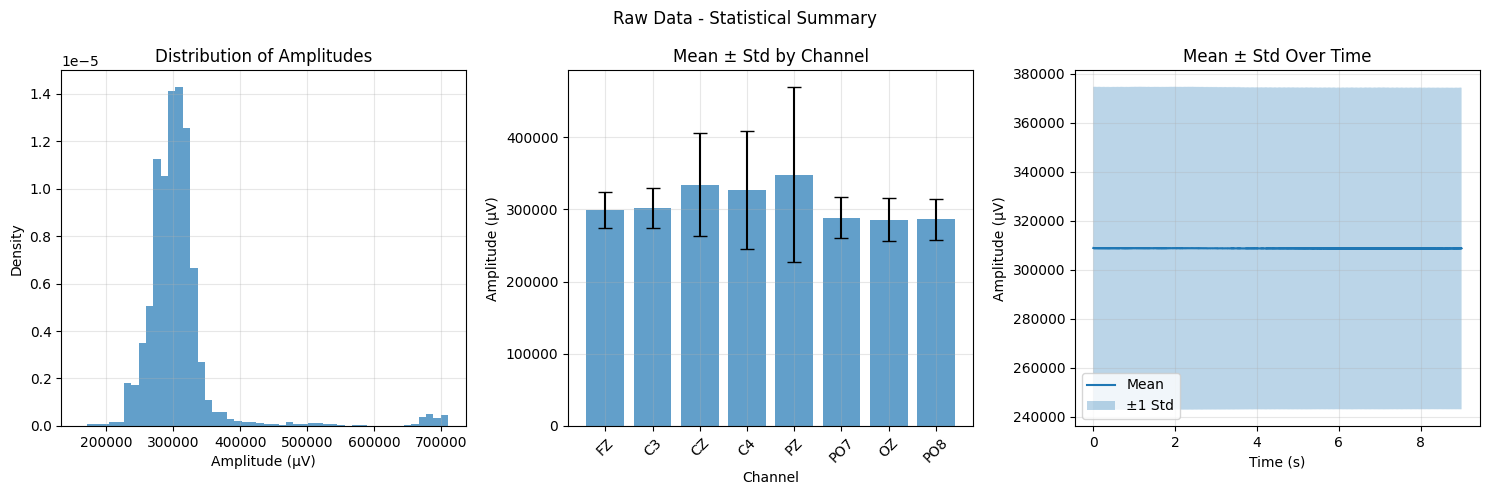

In [9]:
# Plot raw data characteristics
plot_statistical_summary(raw_data_mne, "Raw Data", scaling_factor=1e6)

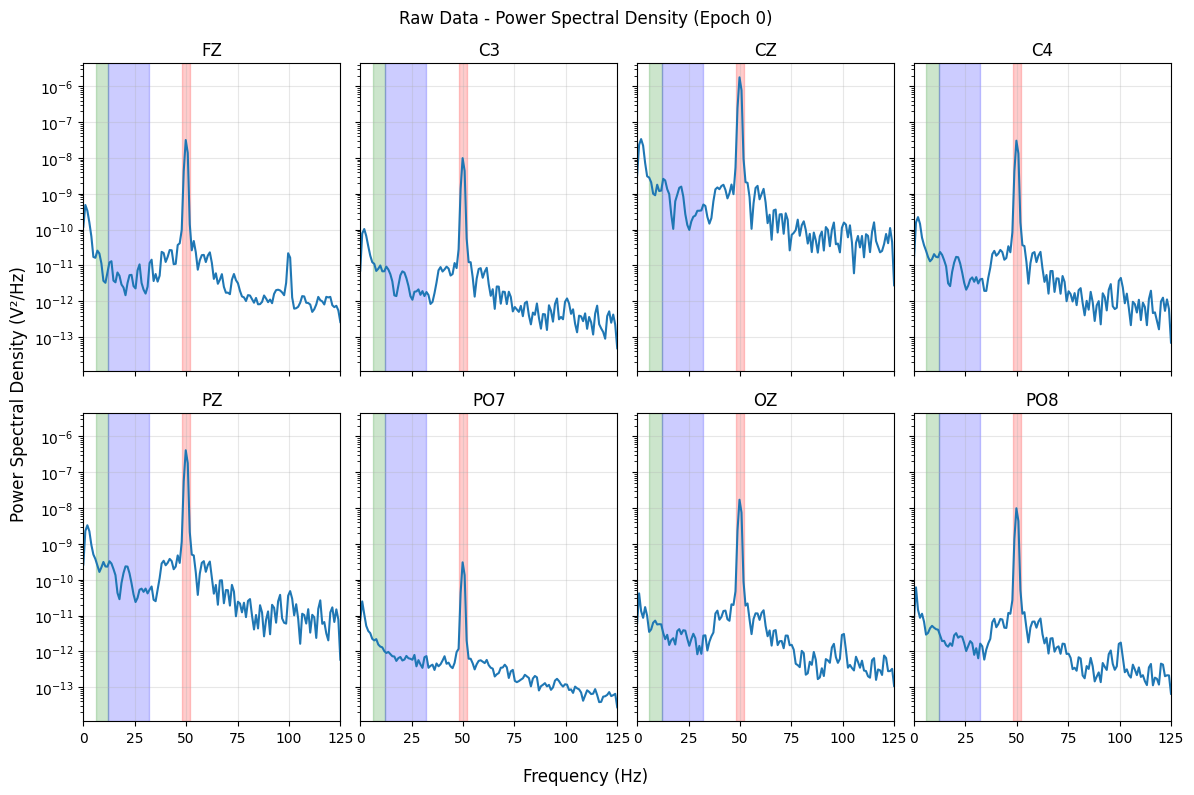

In [10]:
# Plot power spectrum of raw data
plot_power_spectrum(raw_data_mne, sfreq, ch_names, "Raw Data", xlim=(0, 125))

### Observations on Raw Data:
- The raw data shows the typical characteristics of EEG signals
- Power spectrum reveals 50Hz power line noise (visible as a peak)
- Motor imagery relevant frequencies (μ-band: 8-12Hz, β-band: 12-32Hz) are present
- High frequency noise above 32Hz is also visible

## Step 2: Notch Filtering (50Hz Power Line Noise Removal)

Power line interference at 50Hz (60Hz in some countries) is a common artifact in EEG recordings.
We apply a notch filter to remove this specific frequency while preserving other frequencies.

In [11]:
# Apply notch filter
print("Applying notch filter...")
notch_filtered_data = mne.filter.notch_filter(
    raw_data_mne, 
    sfreq, 
    notch_freq, 
    method='fft',
    verbose=False
)

print(f"Notch filter applied at {notch_freq} Hz")

Applying notch filter...
Notch filter applied at 50.0 Hz


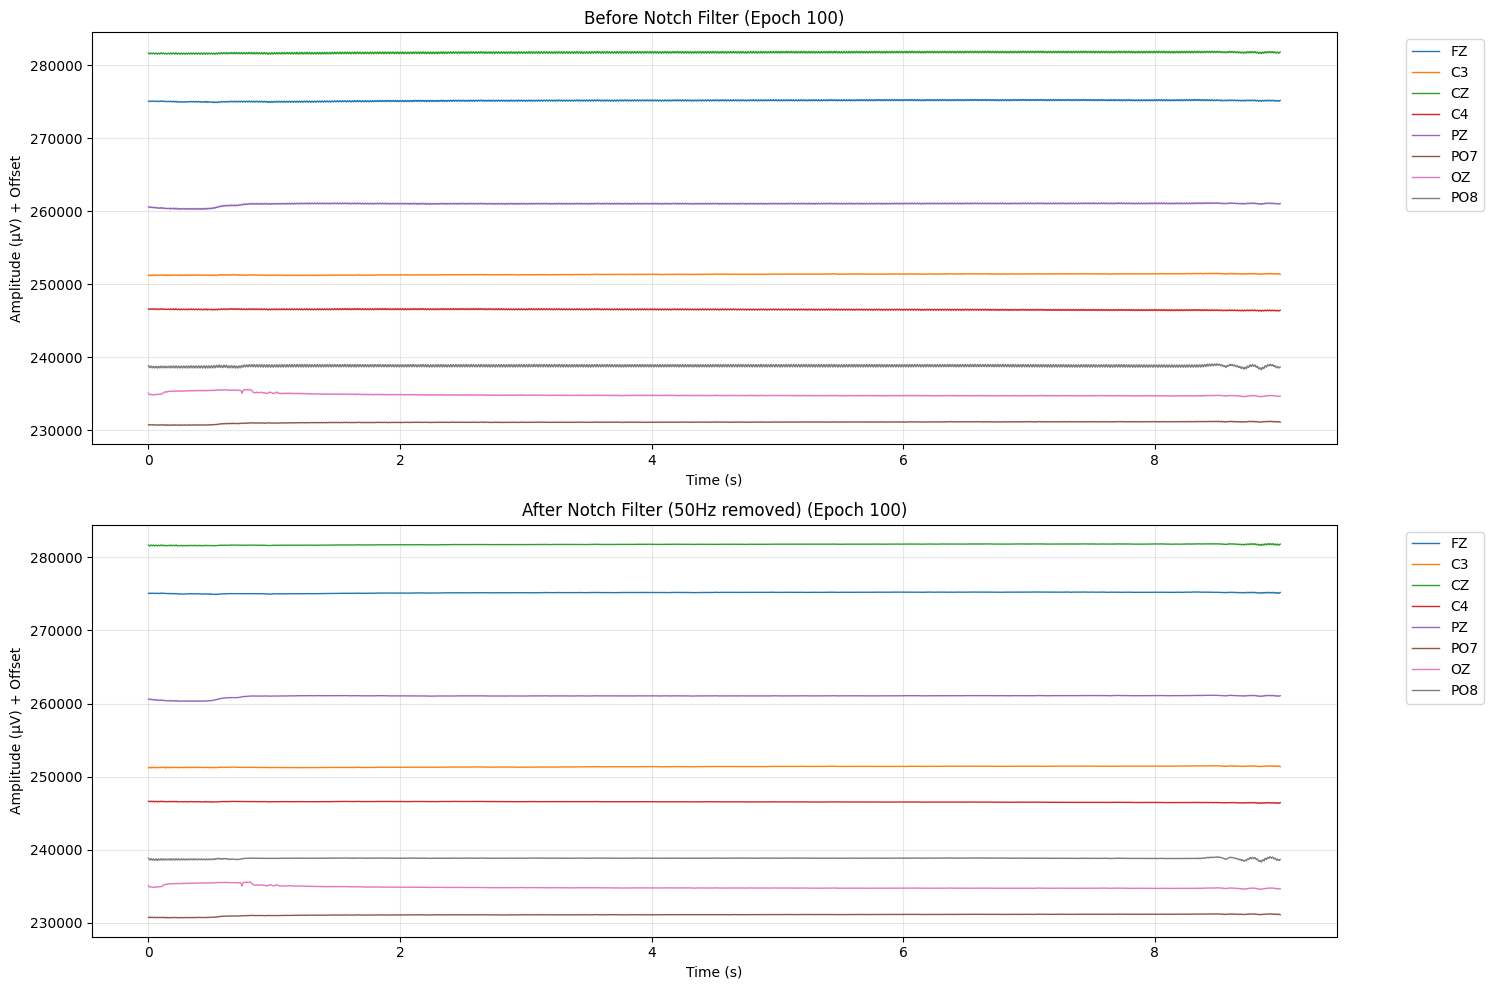

In [12]:
# Compare before and after notch filtering
plot_comparison(
    raw_data_mne, notch_filtered_data, 
    times_raw, times_raw,
    ch_names, 
    "Before Notch Filter", "After Notch Filter (50Hz removed)",
    epoch_idx=100, scaling_factor=1e6
)

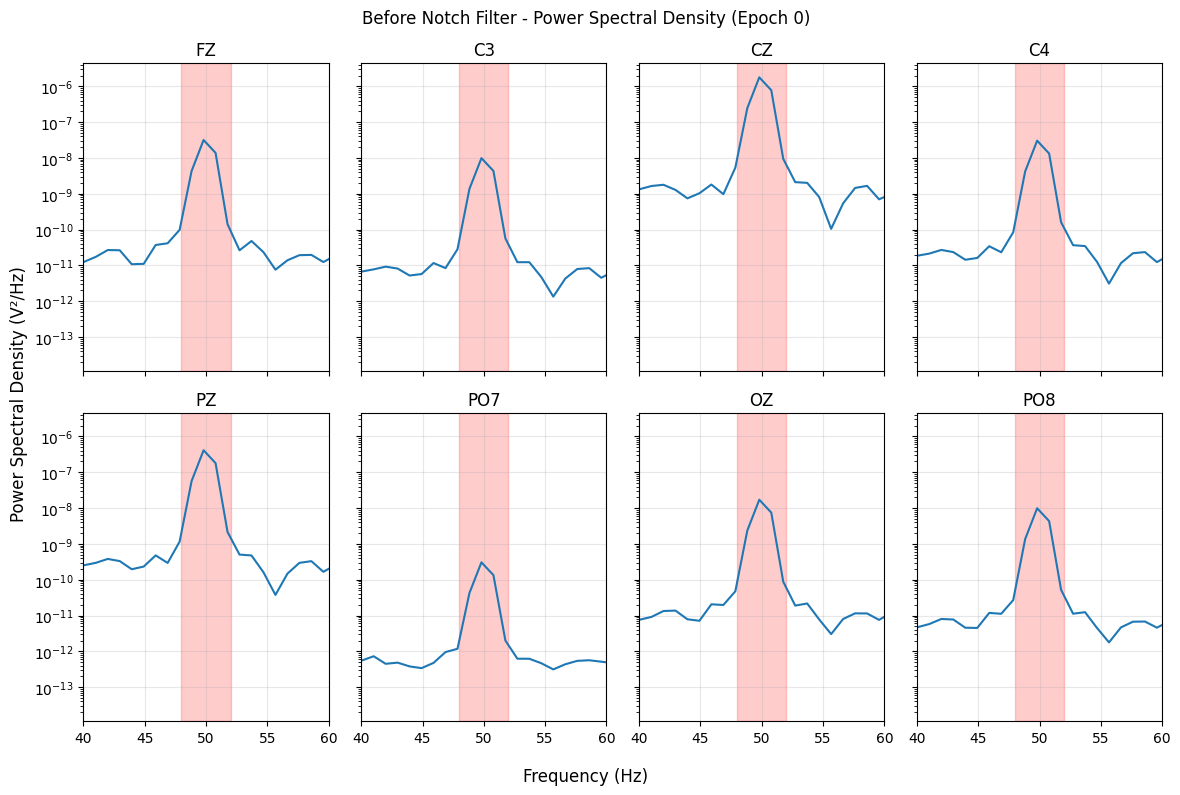

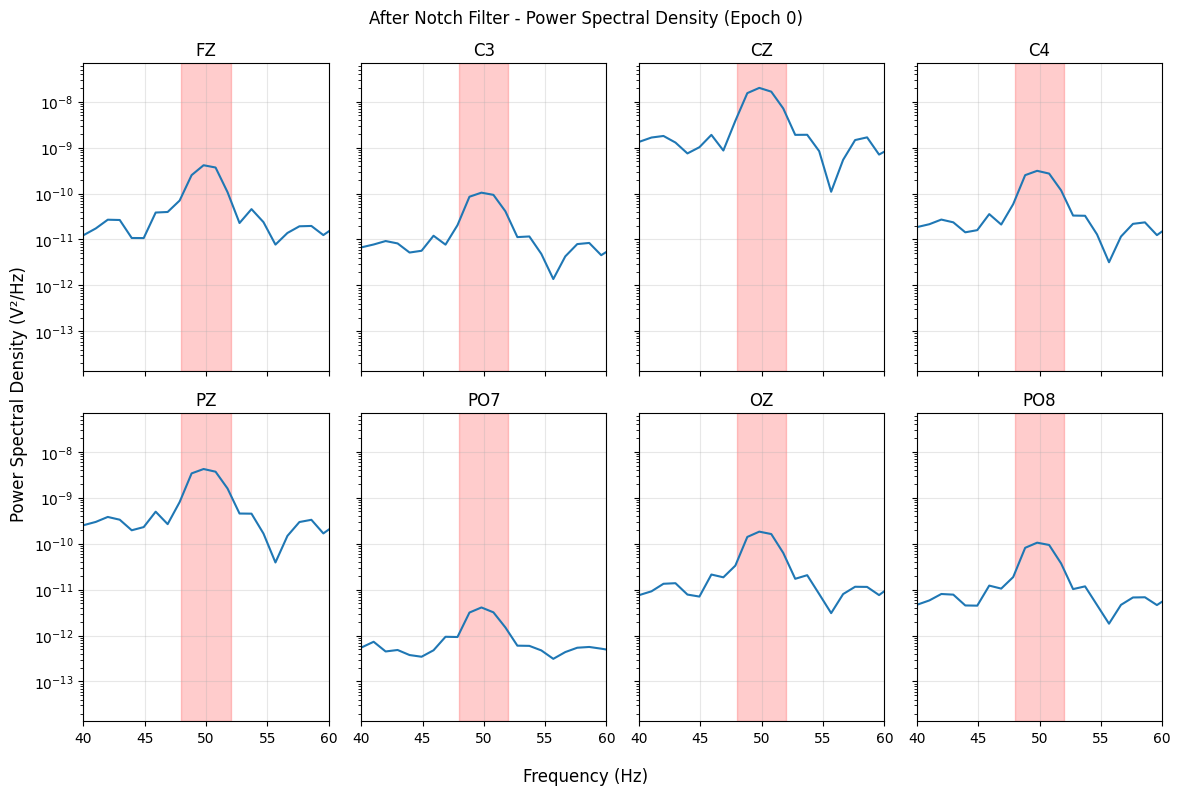

In [13]:
# Compare power spectra
plot_power_spectrum(raw_data_mne, sfreq, ch_names, "Before Notch Filter", xlim=(40, 60))
plot_power_spectrum(notch_filtered_data, sfreq, ch_names, "After Notch Filter", xlim=(40, 60))

### Observations on Notch Filtering:
- The 50Hz power line interference has been successfully removed
- The notch filter creates a sharp attenuation at exactly 50Hz
- Other frequencies remain largely unaffected
- The time-domain signal shows reduced high-frequency noise

## Step 3: Bandpass Filtering (6-32Hz)

Motor imagery signals are primarily contained in the μ-band (8-12Hz) and β-band (12-32Hz).
We apply a bandpass filter to focus on these frequency ranges and remove unwanted low and high frequencies.

In [14]:
# Apply bandpass filter
print("Applying bandpass filter...")
bandpass_filtered_data = mne.filter.filter_data(
    notch_filtered_data, 
    sfreq=sfreq, 
    l_freq=l_freq,
    h_freq=h_freq,
    verbose=False
)

print(f"Bandpass filter applied: {l_freq}-{h_freq} Hz")

Applying bandpass filter...
Bandpass filter applied: 6.0-32.0 Hz


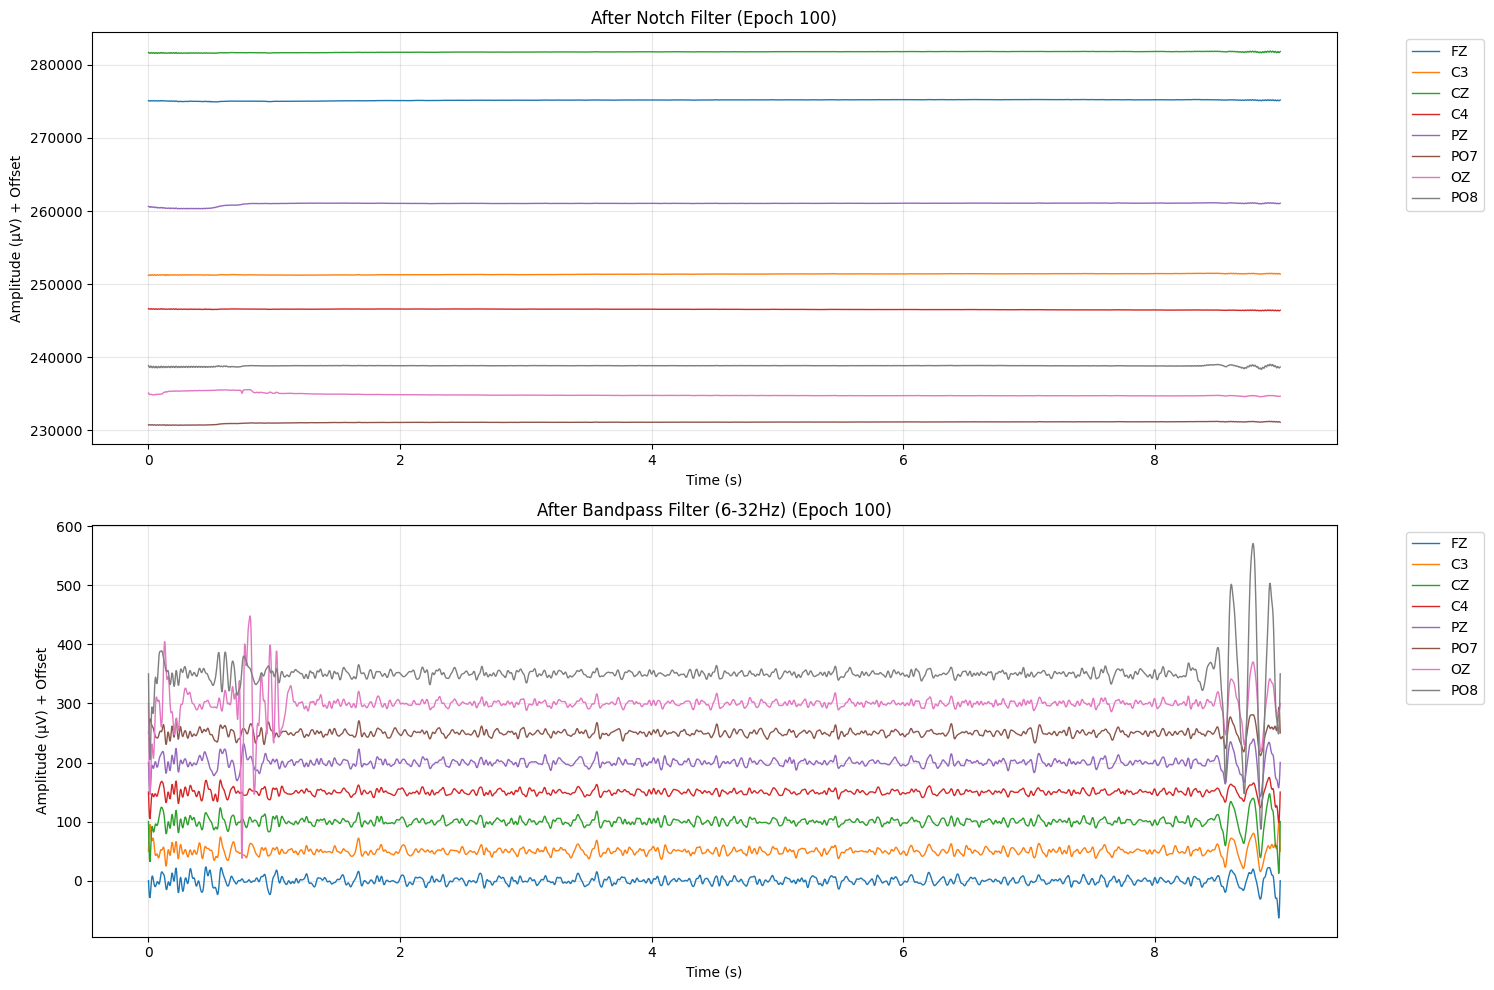

In [15]:
# Compare before and after bandpass filtering
plot_comparison(
    notch_filtered_data, bandpass_filtered_data,
    times_raw, times_raw,
    ch_names,
    "After Notch Filter", "After Bandpass Filter (6-32Hz)",
    epoch_idx=100, scaling_factor=1e6
)

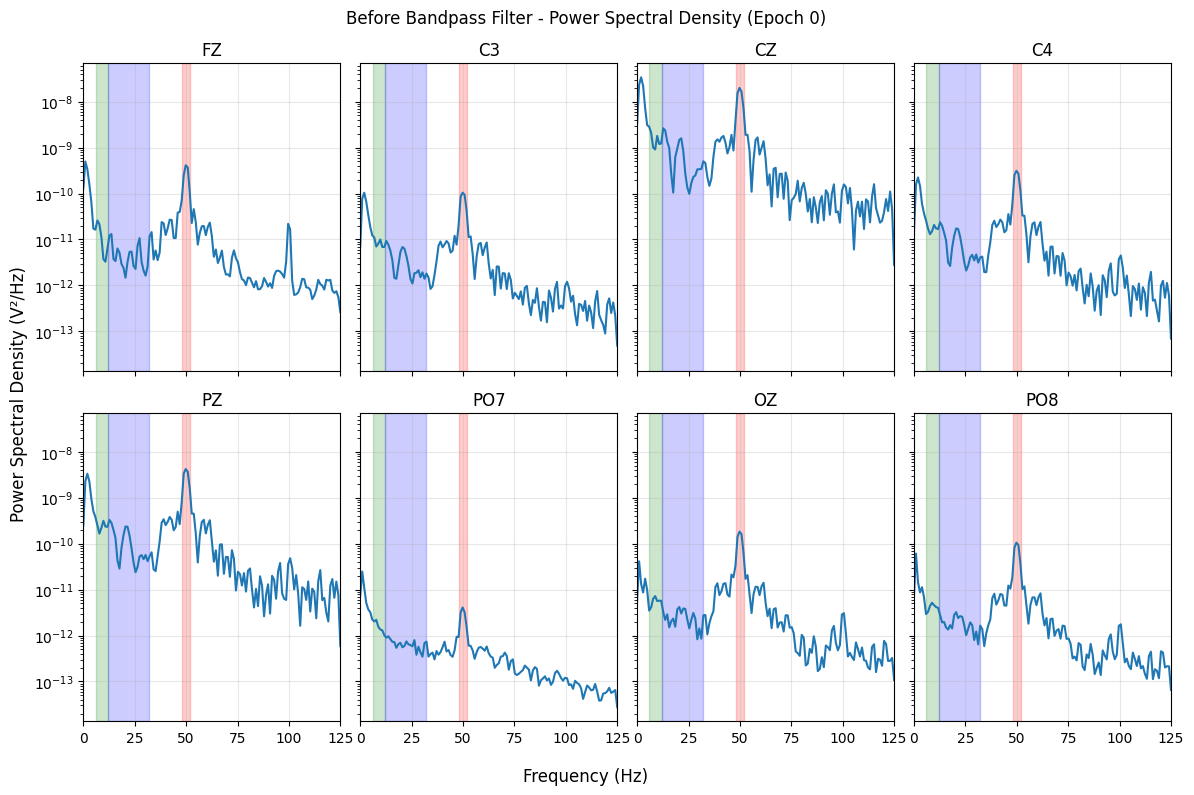

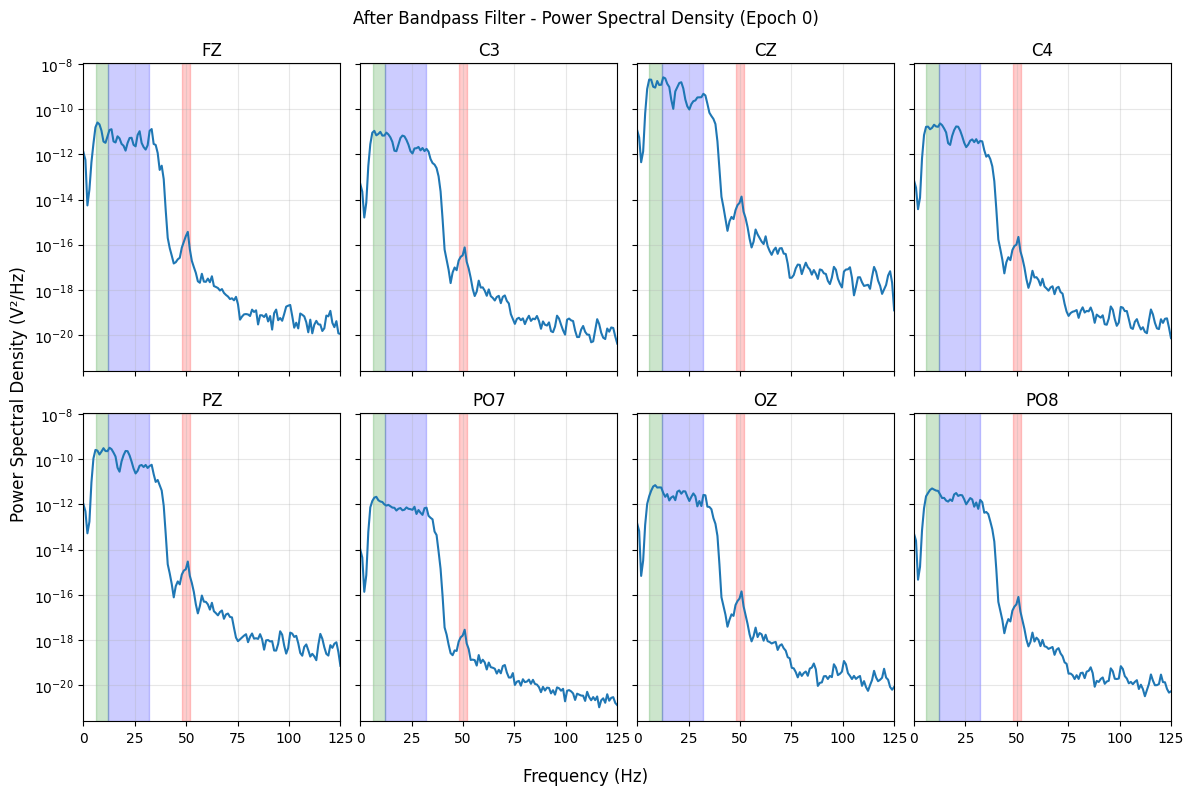

In [16]:
# Compare power spectra - full range
plot_power_spectrum(notch_filtered_data, sfreq, ch_names, "Before Bandpass Filter", xlim=(0, 125))
plot_power_spectrum(bandpass_filtered_data, sfreq, ch_names, "After Bandpass Filter", xlim=(0, 125))

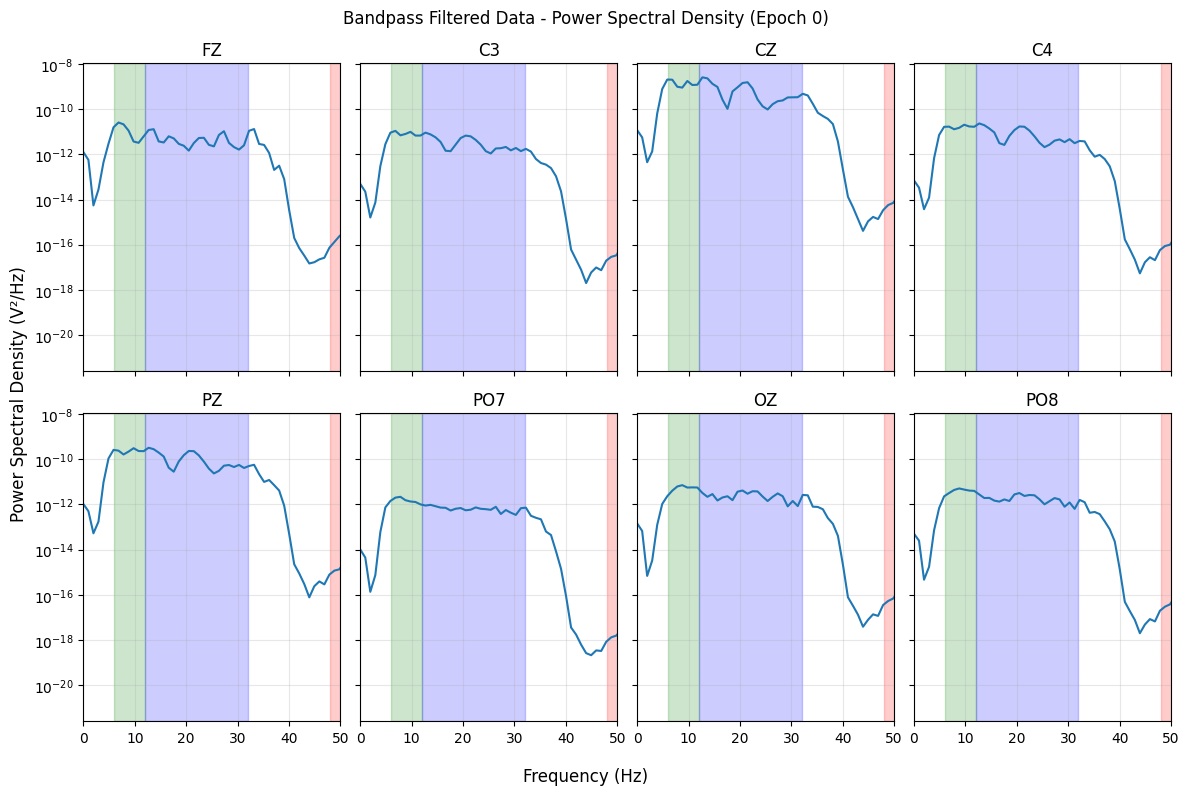

In [17]:
# Focus on the passband
plot_power_spectrum(bandpass_filtered_data, sfreq, ch_names, "Bandpass Filtered Data", xlim=(0, 50))

### Observations on Bandpass Filtering:
- Low frequencies (<6Hz) containing slow drifts and DC components are removed
- High frequencies (>32Hz) containing muscle artifacts and high-frequency noise are removed
- The μ-band (8-12Hz) and β-band (12-32Hz) are preserved, which are crucial for motor imagery
- The filtered signal is cleaner and more focused on the frequencies of interest

## Step 4: Creating MNE Epochs Object

We create an MNE EpochsArray object to use MNE's built-in preprocessing functions.

In [18]:
# Create MNE epochs object
print("Creating MNE epochs object...")
epochs = mne.EpochsArray(
    bandpass_filtered_data, 
    info, 
    events=None, 
    event_id=None, 
    tmin=0.0,
    verbose=False
)

# Add event information for proper epoch handling
epochs.event_id = dict((str(lbl), int(lbl)) for lbl in np.unique(mi_labels))
epochs.events = np.column_stack(
    (np.arange(len(mi_labels)), np.zeros(len(mi_labels), int), mi_labels)
)

print(f"Epochs object created with {len(epochs)} epochs")
print(f"Event IDs: {epochs.event_id}")

Creating MNE epochs object...
Epochs object created with 2400 epochs
Event IDs: {'0': 0, '1': 1}


## Step 5: Baseline Correction

Baseline correction removes the average activity during a reference period (usually before stimulus onset).
This helps to normalize the data and remove slow drifts.

In [19]:
# Get data before baseline correction
pre_baseline_data = epochs.get_data(copy=True)

# Apply baseline correction
print("Applying baseline correction...")
epochs.apply_baseline(baseline=baseline_period, verbose=False)

# Get data after baseline correction
post_baseline_data = epochs.get_data(copy=True)

print(f"Baseline correction applied using period: {baseline_period} s")

Applying baseline correction...
Baseline correction applied using period: (0, 1) s


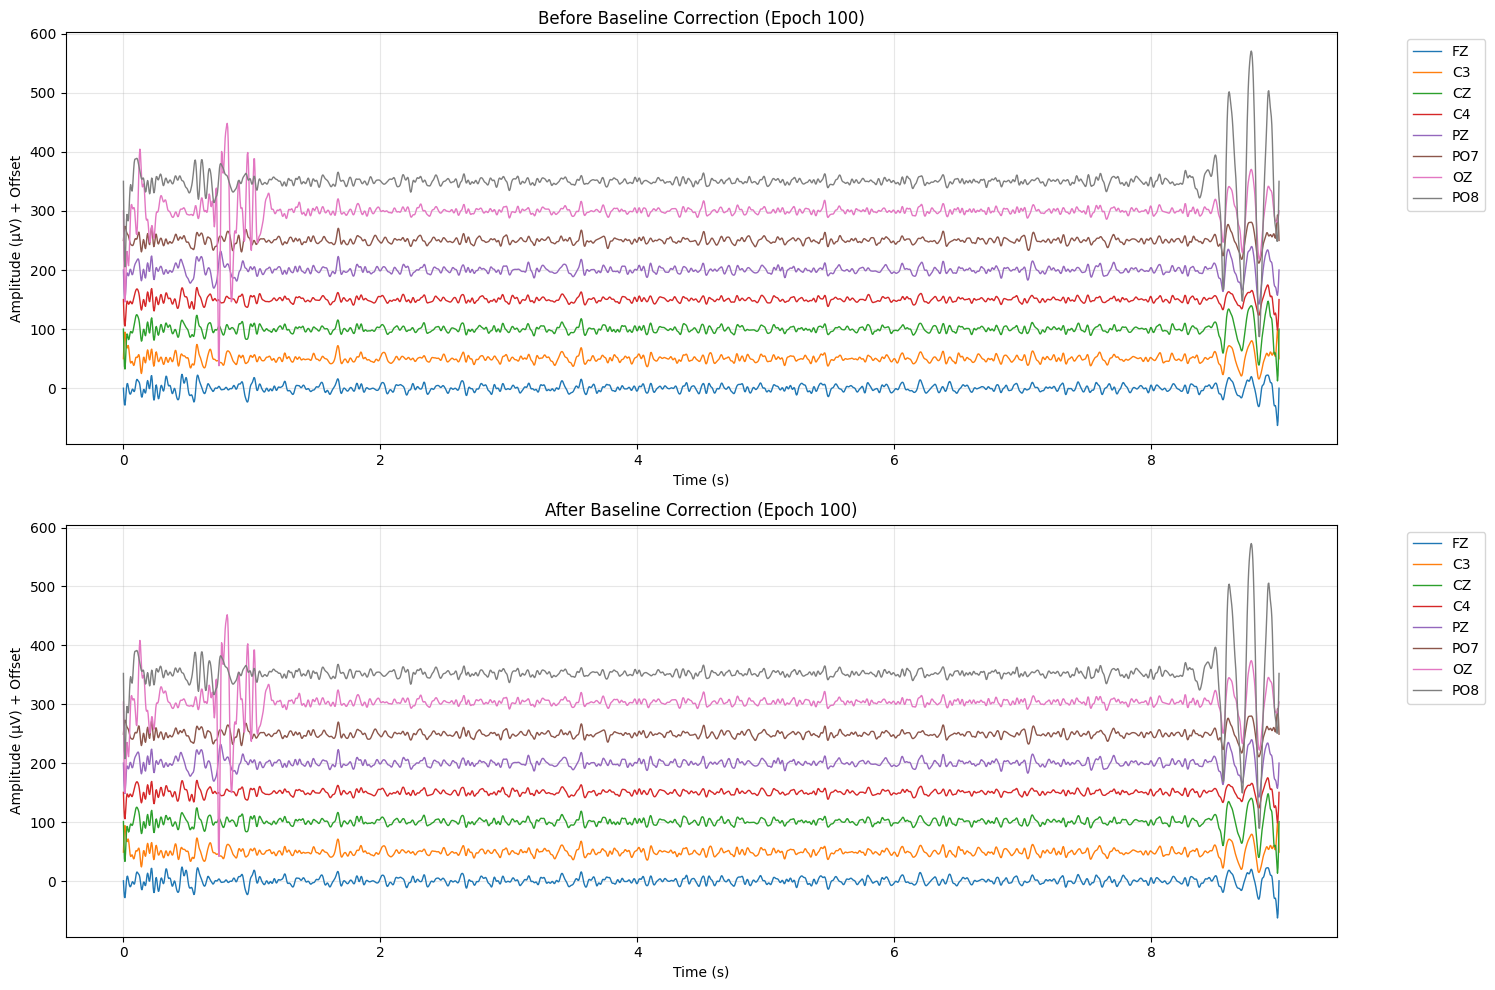

In [20]:
# Compare before and after baseline correction
plot_comparison(
    pre_baseline_data, post_baseline_data,
    epochs.times, epochs.times,
    ch_names,
    "Before Baseline Correction", "After Baseline Correction",
    epoch_idx=100, scaling_factor=1e6
)

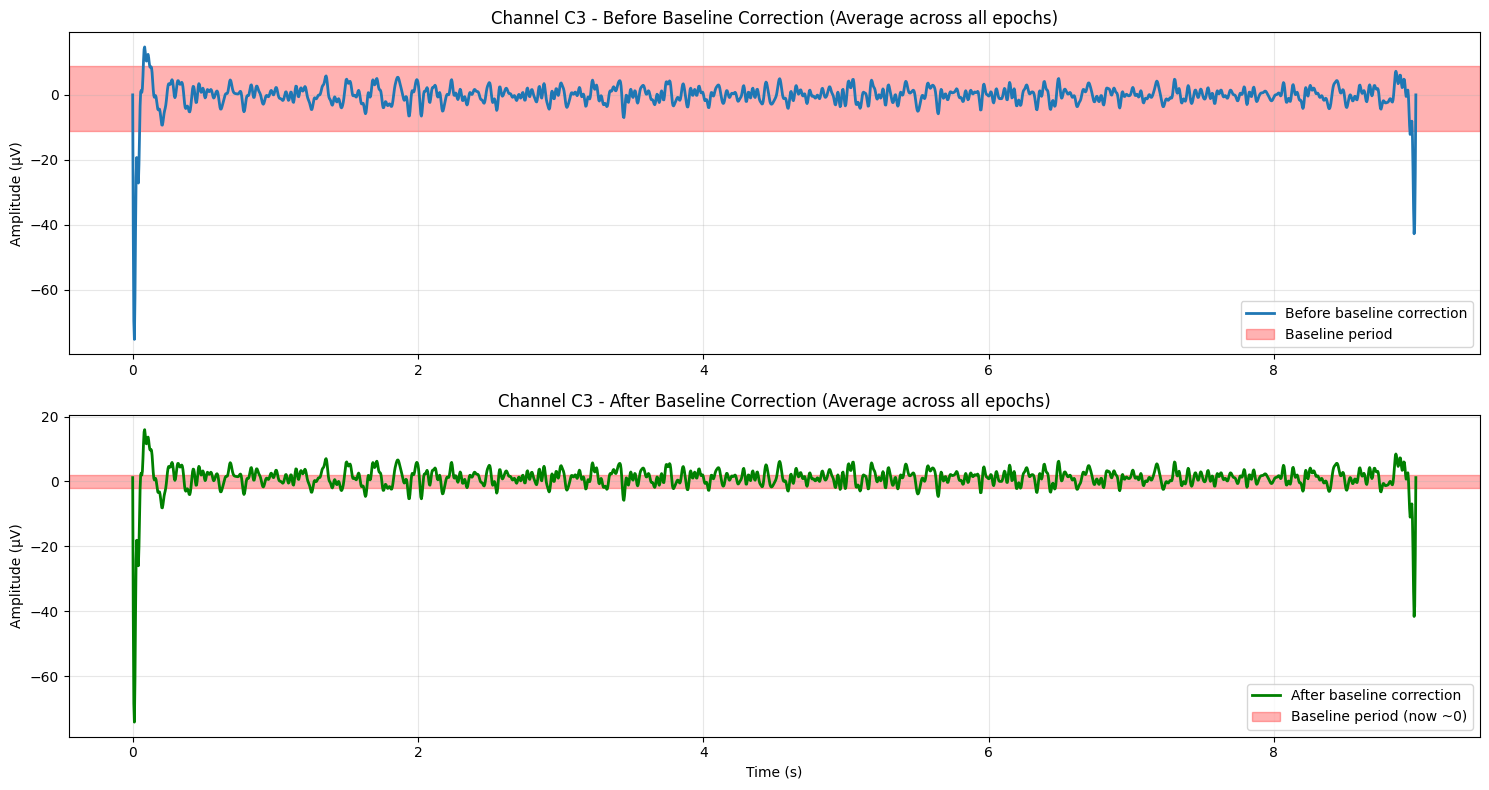

In [21]:
# Show the effect of baseline correction more clearly
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot average across all epochs for one channel (C3 - important for motor imagery)
channel_idx = ch_names.index('C3')
avg_before = np.mean(pre_baseline_data[:, channel_idx, :], axis=0) * 1e6
avg_after = np.mean(post_baseline_data[:, channel_idx, :], axis=0) * 1e6

axes[0].plot(epochs.times, avg_before, label='Before baseline correction', linewidth=2)
axes[0].axhspan(avg_before[int(baseline_period[0]*sfreq):int(baseline_period[1]*sfreq)].mean() - 
                avg_before[int(baseline_period[0]*sfreq):int(baseline_period[1]*sfreq)].std(),
                avg_before[int(baseline_period[0]*sfreq):int(baseline_period[1]*sfreq)].mean() + 
                avg_before[int(baseline_period[0]*sfreq):int(baseline_period[1]*sfreq)].std(),
                alpha=0.3, color='red', label='Baseline period')
axes[0].set_title('Channel C3 - Before Baseline Correction (Average across all epochs)')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs.times, avg_after, label='After baseline correction', linewidth=2, color='green')
axes[1].axhspan(-2, 2, alpha=0.3, color='red', label='Baseline period (now ~0)')
axes[1].set_title('Channel C3 - After Baseline Correction (Average across all epochs)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (µV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

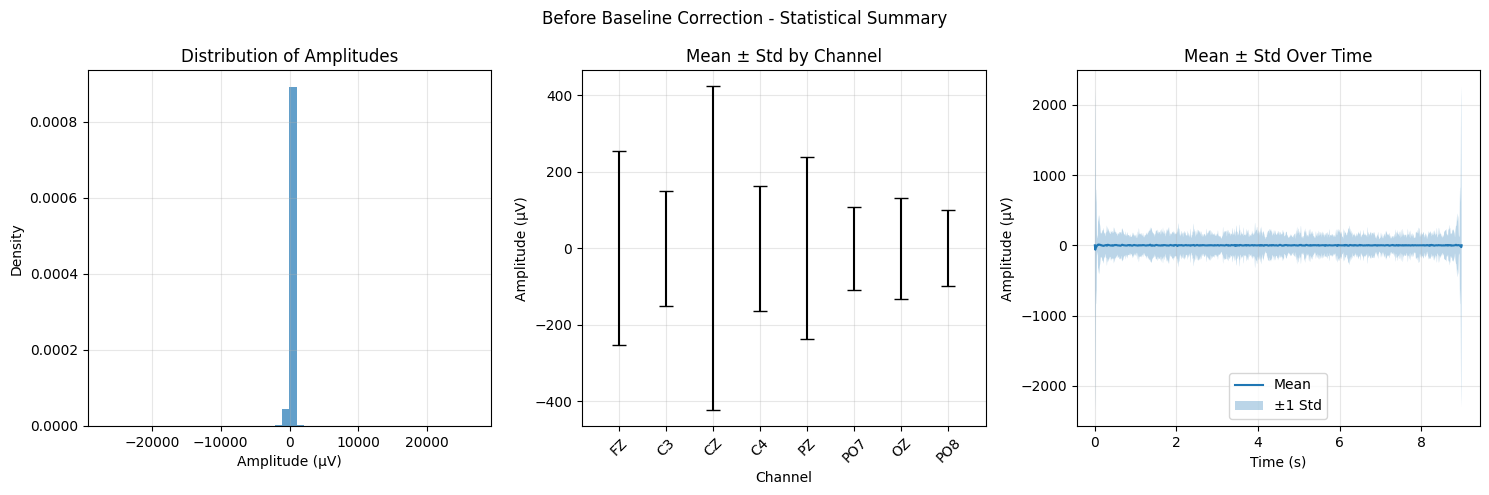

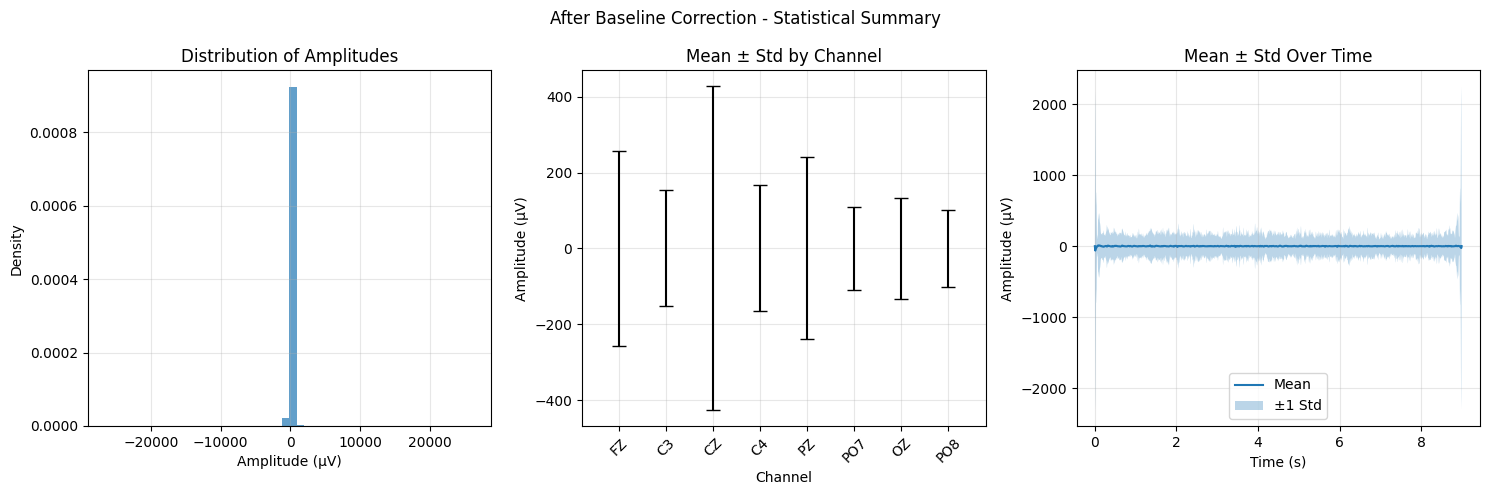

In [22]:
# Statistical comparison
plot_statistical_summary(pre_baseline_data, "Before Baseline Correction", scaling_factor=1e6)
plot_statistical_summary(post_baseline_data, "After Baseline Correction", scaling_factor=1e6)

### Observations on Baseline Correction:
- The baseline period (0-1s) activity is now centered around zero
- This removes slow drifts and DC offsets that could affect classification
- The signal is now relative to the pre-stimulus baseline activity
- The variance in the baseline period is significantly reduced

## Step 6: Epoch Cropping (Motor Imagery Period)

Motor imagery tasks typically show the strongest neural responses during the actual imagination period.
We crop the epochs to focus on this period (2-8 seconds in this case).

In [23]:
# Get data before cropping
pre_crop_data = epochs.get_data(copy=True)
pre_crop_times = epochs.times.copy()

# Crop epochs to motor imagery period
print("Cropping epochs to motor imagery period...")
epochs.crop(tmin=crop_tmin, tmax=crop_tmax, verbose=False)

# Get data after cropping
post_crop_data = epochs.get_data(copy=True)
post_crop_times = epochs.times.copy()

print(f"Epochs cropped to {crop_tmin}-{crop_tmax} s")
print(f"New epoch duration: {post_crop_times[-1] - post_crop_times[0]:.1f} s")
print(f"New data shape: {post_crop_data.shape}")

Cropping epochs to motor imagery period...
Epochs cropped to 2.0-8.0 s
New epoch duration: 6.0 s
New data shape: (2400, 8, 1501)


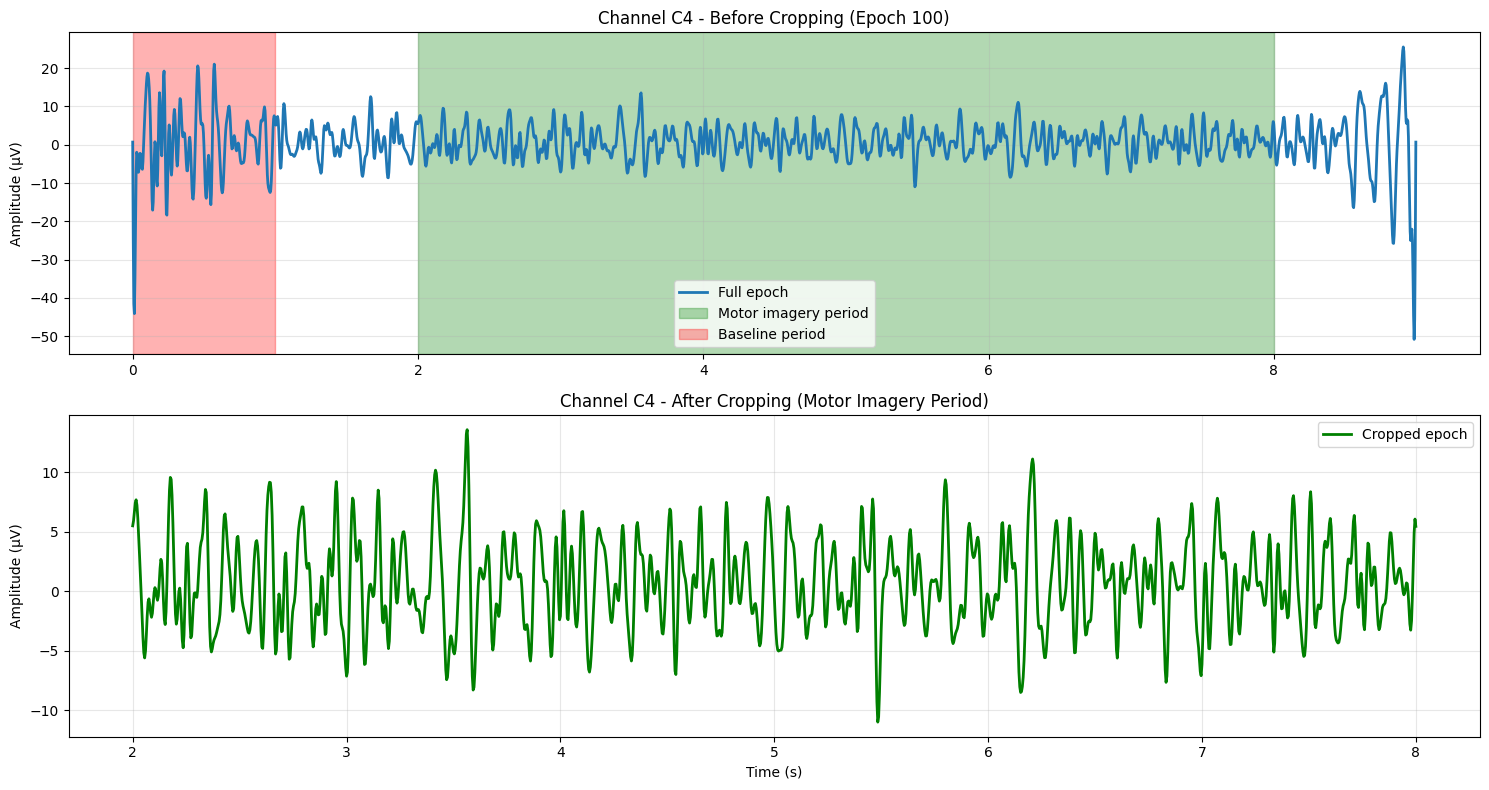

In [24]:
# Compare before and after cropping
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot one channel for clarity
channel_idx = ch_names.index('C4')
epoch_idx = 100

# Before cropping
axes[0].plot(pre_crop_times, pre_crop_data[epoch_idx, channel_idx, :] * 1e6, 
            linewidth=2, label='Full epoch')
axes[0].axvspan(crop_tmin, crop_tmax, alpha=0.3, color='green', 
               label='Motor imagery period')
axes[0].axvspan(baseline_period[0], baseline_period[1], alpha=0.3, color='red', 
               label='Baseline period')
axes[0].set_title(f'Channel {ch_names[channel_idx]} - Before Cropping (Epoch {epoch_idx})')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After cropping
axes[1].plot(post_crop_times, post_crop_data[epoch_idx, channel_idx, :] * 1e6, 
            linewidth=2, color='green', label='Cropped epoch')
axes[1].set_title(f'Channel {ch_names[channel_idx]} - After Cropping (Motor Imagery Period)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (µV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

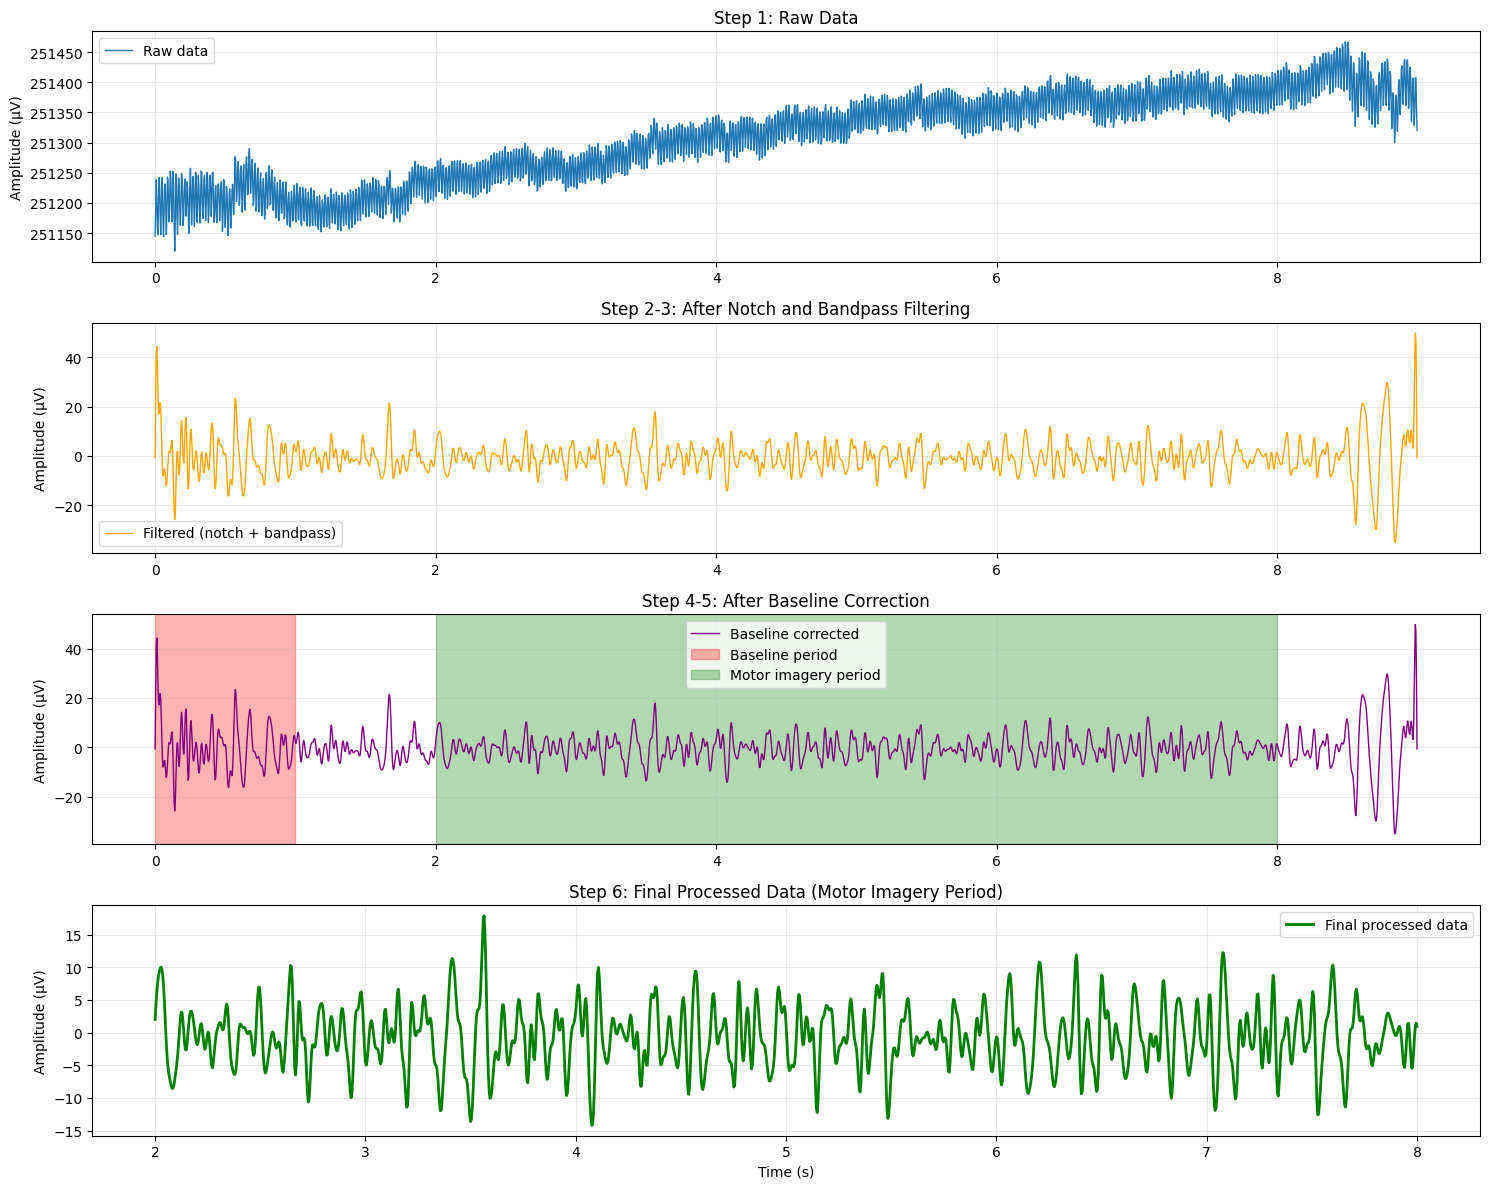

In [25]:
# Compare the full preprocessing pipeline
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

channel_idx = ch_names.index('C3')
epoch_idx = 100

# Original raw data
axes[0].plot(times_raw, raw_data_mne[epoch_idx, channel_idx, :] * 1e6, 
            linewidth=1, label='Raw data')
axes[0].set_title('Step 1: Raw Data')
axes[0].set_ylabel('Amplitude (µV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After notch and bandpass filtering
axes[1].plot(times_raw, bandpass_filtered_data[epoch_idx, channel_idx, :] * 1e6, 
            linewidth=1, color='orange', label='Filtered (notch + bandpass)')
axes[1].set_title('Step 2-3: After Notch and Bandpass Filtering')
axes[1].set_ylabel('Amplitude (µV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# After baseline correction
axes[2].plot(pre_crop_times, pre_crop_data[epoch_idx, channel_idx, :] * 1e6, 
            linewidth=1, color='purple', label='Baseline corrected')
axes[2].axvspan(baseline_period[0], baseline_period[1], alpha=0.3, color='red', 
               label='Baseline period')
axes[2].axvspan(crop_tmin, crop_tmax, alpha=0.3, color='green', 
               label='Motor imagery period')
axes[2].set_title('Step 4-5: After Baseline Correction')
axes[2].set_ylabel('Amplitude (µV)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Final processed data
axes[3].plot(post_crop_times, post_crop_data[epoch_idx, channel_idx, :] * 1e6, 
            linewidth=2, color='green', label='Final processed data')
axes[3].set_title('Step 6: Final Processed Data (Motor Imagery Period)')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Amplitude (µV)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Processing Summary

In [26]:
# Get final processed data
final_processed_data = epochs.get_data(copy=True)

# Print processing summary
print("=== PREPROCESSING SUMMARY ===")
print(f"Original data shape: {mi_data.shape}")
print(f"Final data shape: {final_processed_data.shape}")
print(f"Original duration: {mi_data.shape[2] / sfreq:.1f} seconds")
print(f"Final duration: {final_processed_data.shape[2] / sfreq:.1f} seconds")
print(f"Sampling rate: {sfreq} Hz")
print(f"Number of channels: {len(ch_names)}")
print(f"Number of epochs: {len(epochs)}")

print("\nProcessing steps applied:")
print(f"1. Notch filter: {notch_freq} Hz")
print(f"2. Bandpass filter: {l_freq}-{h_freq} Hz")
print(f"3. Baseline correction: {baseline_period} s")
print(f"4. Epoch cropping: {crop_tmin}-{crop_tmax} s")

print("\nFinal data statistics:")
print(f"Min: {final_processed_data.min():.2e} V")
print(f"Max: {final_processed_data.max():.2e} V")
print(f"Mean: {final_processed_data.mean():.2e} V")
print(f"Std: {final_processed_data.std():.2e} V")

=== PREPROCESSING SUMMARY ===
Original data shape: (2400, 8, 2250)
Final data shape: (2400, 8, 1501)
Original duration: 9.0 seconds
Final duration: 6.0 seconds
Sampling rate: 250.0 Hz
Number of channels: 8
Number of epochs: 2400

Processing steps applied:
1. Notch filter: 50.0 Hz
2. Bandpass filter: 6.0-32.0 Hz
3. Baseline correction: (0, 1) s
4. Epoch cropping: 2.0-8.0 s

Final data statistics:
Min: -2.58e-02 V
Max: 2.44e-02 V
Mean: 8.95e-07 V
Std: 1.74e-04 V


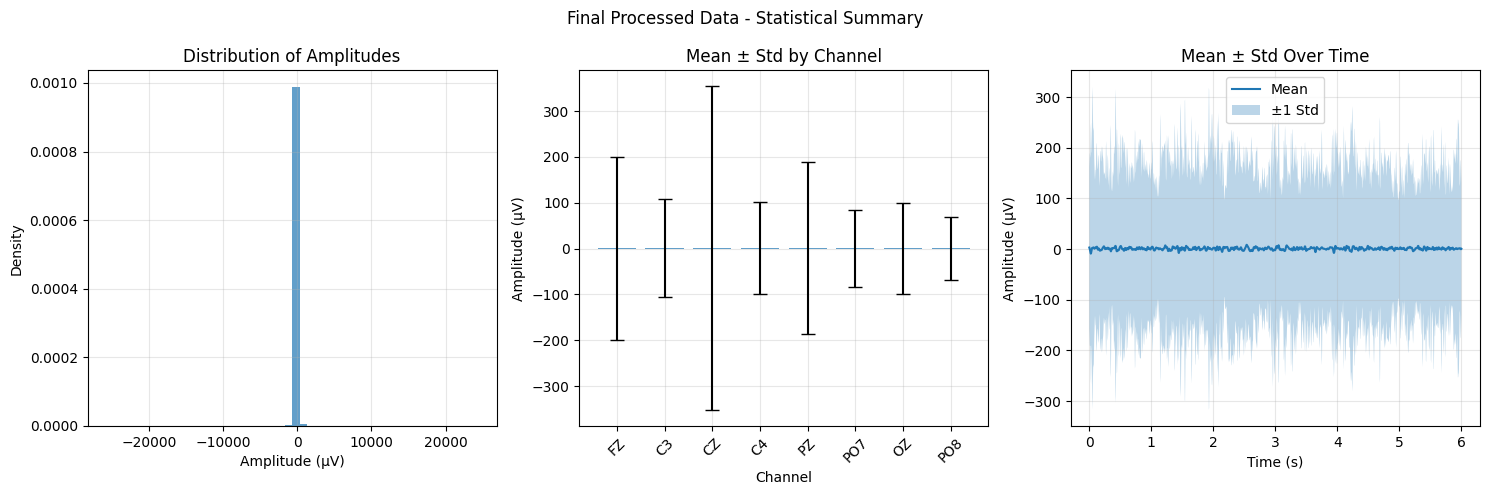

In [27]:
# Final statistical summary
plot_statistical_summary(final_processed_data, "Final Processed Data", scaling_factor=1e6)

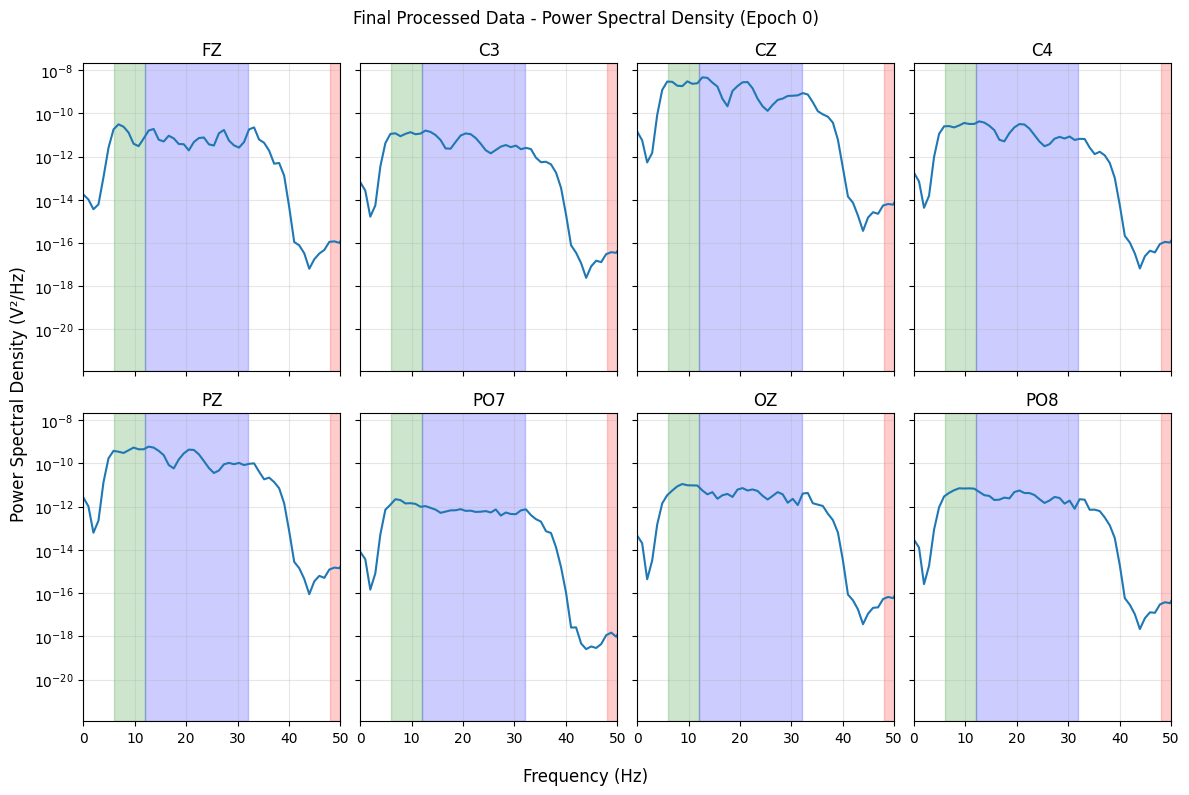

In [28]:
# Final power spectrum analysis
plot_power_spectrum(final_processed_data, sfreq, ch_names, "Final Processed Data", xlim=(0, 50))

## Export Processed Data

The processed data is now ready for machine learning models like EEGNet.

In [29]:
# Convert back to the format expected by your training pipeline
# (matching the original scaling and data type)
final_data_for_training = final_processed_data / SCALING_FACTOR  # Convert back to original scale
final_data_for_training = final_data_for_training.astype(np.float32)

print("Data ready for training:")
print(f"Shape: {final_data_for_training.shape}")
print(f"Dtype: {final_data_for_training.dtype}")
print(f"Min: {final_data_for_training.min():.2f}")
print(f"Max: {final_data_for_training.max():.2f}")
print(f"Mean: {final_data_for_training.mean():.2f}")
print(f"Std: {final_data_for_training.std():.2f}")

Data ready for training:
Shape: (2400, 8, 1501)
Dtype: float32
Min: -25770.93
Max: 24409.44
Mean: 0.89
Std: 174.02


In [30]:
# You can now use this processed data for training
# Example: Convert to PyTorch tensors
processed_tensor = torch.from_numpy(final_data_for_training)
labels_tensor = torch.from_numpy(mi_labels.astype(np.long))

print(f"PyTorch tensors created:")
print(f"Data tensor shape: {processed_tensor.shape}")
print(f"Labels tensor shape: {labels_tensor.shape}")

PyTorch tensors created:
Data tensor shape: torch.Size([2400, 8, 1501])
Labels tensor shape: torch.Size([2400])


## Key Insights from Preprocessing

1. **Notch Filtering**: Successfully removed 50Hz power line interference without affecting other frequencies
2. **Bandpass Filtering**: Focused on motor imagery relevant frequencies (6-32Hz), removing low-frequency drifts and high-frequency noise
3. **Baseline Correction**: Normalized the data relative to pre-stimulus activity, centering the baseline around zero
4. **Epoch Cropping**: Focused on the motor imagery period (2-8s), removing irrelevant time periods

The processed data is now optimized for motor imagery classification with:
- Reduced noise and artifacts
- Enhanced signal-to-noise ratio in relevant frequency bands
- Consistent baseline across all epochs
- Focused temporal window for motor imagery activity